BZAN 542

Charles Liu

# Packages

In [1]:
library(tidyverse) #https://tidyverse.org/
library(yardstick) #https://yardstick.tidymodels.org/
library(GGally)
library(caret)
library(rpart.plot)

#Please try:
# https://cran.r-project.org/web/packages/dplyr/vignettes/dplyr.html
# https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘yardstick’


The following object is masked from ‘package:readr’:

    spec


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:yardstick’:

    precision, recall, sensitivity, specificity


The following object is masked from ‘package:purrr’:

    lift


Loading required package: rpart



# Data Processing

Please learn more information about the data: https://www.lendingclub.com/info/download-data.action

In [2]:
df = read.csv("LoanStats3a.csv", skip=1)
dim(df)

[1] 42538   145

A comprehensive summary:

In [3]:
summary(df)

      id            member_id        loan_amnt      funded_amnt   
 Length:42538       Mode:logical   Min.   :  500   Min.   :  500  
 Class :character   NA's:42538     1st Qu.: 5200   1st Qu.: 5000  
 Mode  :character                  Median : 9700   Median : 9600  
                                   Mean   :11090   Mean   :10822  
                                   3rd Qu.:15000   3rd Qu.:15000  
                                   Max.   :35000   Max.   :35000  
                                   NA's   :3       NA's   :3      
 funded_amnt_inv     term             int_rate          installment     
 Min.   :    0   Length:42538       Length:42538       Min.   :  15.67  
 1st Qu.: 4950   Class :character   Class :character   1st Qu.: 165.52  
 Median : 8500   Mode  :character   Mode  :character   Median : 277.69  
 Mean   :10140                                         Mean   : 322.62  
 3rd Qu.:14000                                         3rd Qu.: 428.18  
 Max.   :35000            

## Classification of loan status

In [4]:
table(df$loan_status)


                                                    
                                                  3 
                                        Charged Off 
                                               5670 
Does not meet the credit policy. Status:Charged Off 
                                                761 
 Does not meet the credit policy. Status:Fully Paid 
                                               1988 
                                         Fully Paid 
                                              34116 

We will focus on the two major classes.

Note that, you may want to keep more than two class for your data, and many algorithms can naturally handle more than two classes.

In [5]:
df = df %>%
    filter(loan_status %in% c('Charged Off', 'Fully Paid')) %>%
    droplevels()
table(df$loan_status)


Charged Off  Fully Paid 
       5670       34116 

Let's aim to detect loan status being charged off.
Obviously, the two classes are imbalanced.

## What are the features?

The features should be selected according to your domain knowledge. One important issue is that we cannot use information that is collected later than the collection of classes, because using that information is impossible in reality even if such information is included in the data.

In [6]:
df.model = df %>%
    select(term, grade, emp_length, home_ownership, annual_inc,
           purpose, pymnt_plan, out_prncp_inv, delinq_2yrs,
           int_rate, revol_util, pub_rec_bankruptcies,
           loan_status)
dim(df.model)

[1] 39786    13

## Do we have any format issues?

__According to the summary, there are columns containing '%', so let's check more details:__

* find all columns where we can detect '%'
* then count their frequencies

In [7]:
df.model %>%
    summarise_if( ~any(str_detect(., '%')), ~sum(str_detect(., '%')) )

int_rate,revol_util
<int>,<int>
39786,39736


The details show that the column int_rate has '%' in all records, but the column revol_util is very strange:
the frequency is 50 less!
what do we have when we cannot detect '%'?
It turns out that we have '', which can be deemed missing values:

In [8]:
df.model %>%
    filter(!str_detect(revol_util, '%')) %>%
    group_by(revol_util) %>%
    summarise(n())

revol_util,n()
<chr>,<int>
,50


Now we can convert character percentages to numeric variables:

In [9]:
df.model = df.model %>%
    mutate(
        int_rate = as.numeric(str_replace(int_rate, "%" , ""))
        ,
        revol_util = as.numeric(str_replace(revol_util, "%" , ""))
    )

Summary of converted numeric variables.
Note that there are 50 NA's in column revol_util.

In [10]:
df.model %>% select(int_rate, revol_util) %>% summary

    int_rate       revol_util   
 Min.   : 5.42   Min.   : 0.00  
 1st Qu.: 9.25   1st Qu.:25.40  
 Median :11.86   Median :49.30  
 Mean   :12.03   Mean   :48.86  
 3rd Qu.:14.59   3rd Qu.:72.40  
 Max.   :24.59   Max.   :99.90  
                 NA's   :50     

__Another column we may want to convert to numeric is emp_length:__

The following line is very similar with the `table` function

In [11]:
df.model %>% group_by(emp_length) %>% summarise(n())

emp_length,n()
<chr>,<int>
1 year,3247
10+ years,8899
2 years,4394
3 years,4098
4 years,3444
5 years,3286
6 years,2231
7 years,1775
8 years,1485


We will convert 10+ to be 10.5 and <1 to be 0.5.
You can also try other choices based on your understanding and performance comparison.
In addition, we will convert 'n/a' to be NA.

In [12]:
df.model = df.model %>%
    mutate(
        emp_length = case_when( # first find the numeric part
            emp_length=='10+ years' ~ '10.5'
            ,
            emp_length=='< 1 year' ~ '0.5'
            ,
            emp_length=='n/a' ~ ''
            ,
            TRUE ~ substr(emp_length, 1, 1)
        )
        ,
        emp_length = as.numeric(emp_length) # then convert to numeric column
    )
class(df.model$emp_length)
table(df.model$emp_length)
summary(df.model$emp_length)

[1] "numeric"


 0.5    1    2    3    4    5    6    7    8    9 10.5 
4590 3247 4394 4098 3444 3286 2231 1775 1485 1259 8899 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.500   2.000   4.000   5.149   9.000  10.500    1078 

## Do we have any character columns?

If so, we can convert character columns to factor columns.

In [13]:
sapply(df.model, class)

term                grade           emp_length 
         "character"          "character"            "numeric" 
      home_ownership           annual_inc              purpose 
         "character"            "numeric"          "character" 
          pymnt_plan        out_prncp_inv          delinq_2yrs 
         "character"            "numeric"            "integer" 
            int_rate           revol_util pub_rec_bankruptcies 
           "numeric"            "numeric"            "integer" 
         loan_status 
         "character"

In [14]:
df.model = df.model %>%
    mutate_if(is.character, as.factor)
sapply(df.model, class)

term                grade           emp_length 
            "factor"             "factor"            "numeric" 
      home_ownership           annual_inc              purpose 
            "factor"            "numeric"             "factor" 
          pymnt_plan        out_prncp_inv          delinq_2yrs 
            "factor"            "numeric"            "integer" 
            int_rate           revol_util pub_rec_bankruptcies 
           "numeric"            "numeric"            "integer" 
         loan_status 
            "factor"

## Do we have any ordered factors?

The column grade should be ordered:

In [15]:
class(df.model$grade)
table(df.model$grade)

[1] "factor"


    A     B     C     D     E     F     G 
10085 12035  8111  5325  2858  1054   318 

In [16]:
df.model = df.model %>%
    mutate(
        grade=ordered(grade)
    )
class(df.model$grade)
table(df.model$grade)

[1] "ordered" "factor"


    A     B     C     D     E     F     G 
10085 12035  8111  5325  2858  1054   318 

## Do we have any empty or constant columns?

In [17]:
col_distincts = summarise_all(df.model, ~n_distinct(., na.rm = T))
col_distincts

term,grade,emp_length,home_ownership,annual_inc,purpose,pymnt_plan,out_prncp_inv,delinq_2yrs,int_rate,revol_util,pub_rec_bankruptcies,loan_status
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2,7,11,5,5323,14,1,1,11,371,1089,3,2


In [18]:
col_distincts[, col_distincts <= 1]

pymnt_plan,out_prncp_inv
<int>,<int>
1,1


We do!

* If the number is 0, the column has only missing values. We don't have such columns;
* If the number is 1, the column has only one value, such as `pymnt_plan`;

Let's drop such columns:

In [19]:
df.model=df.model[, col_distincts > 1 ]
dim(df.model)

[1] 39786    11

## Do we have factor columns having too many levels?

In [20]:
col_levels = summarise_all(df.model, ~is.factor(.)*n_distinct(., na.rm = T))
col_levels

term,grade,emp_length,home_ownership,annual_inc,purpose,delinq_2yrs,int_rate,revol_util,pub_rec_bankruptcies,loan_status
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2,7,0,5,0,14,0,0,0,0,2


Note that:
* If the number is zero, the column is not factor;
* If the number is positive, it is the number of factor levels;

Therefore:
* we have 6 numeric columns;
* we have two columns having two levels, three columns having 5, 7, and 14 levels, respectively;

Let's check the levels of the column `purpose`:

In [21]:
df.model %>% group_by(purpose) %>% summarise(n())

purpose,n()
<fct>,<int>
car,1551
credit_card,5137
debt_consolidation,18676
educational,325
home_improvement,2985
house,382
major_purchase,2188
medical,695
moving,583


Since the levels seem reasonable, we will keep them. Otherwise, you may want to simplify complicated levels, e.g., combining similar levels or just dropping columns with little useful information.

## Do we have any missing values?

In [22]:
col_nas = summarise_all( df.model, ~mean(is.na(.)) )
col_nas

term,grade,emp_length,home_ownership,annual_inc,purpose,delinq_2yrs,int_rate,revol_util,pub_rec_bankruptcies,loan_status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0.02709496,0,0,0,0,0,0.001256723,0.01751873,0


We have missing values in several columns.
Since the missing fraction is low, we can continue to fix them.
Otherwise, if the missing fraction of a column is very high, we may have to drop the column.

Let's `fix` the missing values:
* replace missing values in emp_length and revol_util with mean of the available values.
* replace missing values in pub_rec_bankruptcies with zero, since that might mean there is no public records of bankruptcies.

In [23]:
df.model %>%
    select_if(~any(is.na(.))) %>%
    summary()

   emp_length       revol_util    pub_rec_bankruptcies
 Min.   : 0.500   Min.   : 0.00   Min.   :0.0000      
 1st Qu.: 2.000   1st Qu.:25.40   1st Qu.:0.0000      
 Median : 4.000   Median :49.30   Median :0.0000      
 Mean   : 5.149   Mean   :48.86   Mean   :0.0433      
 3rd Qu.: 9.000   3rd Qu.:72.40   3rd Qu.:0.0000      
 Max.   :10.500   Max.   :99.90   Max.   :2.0000      
 NA's   :1078     NA's   :50      NA's   :697         

In [24]:
df.model = df.model %>%
    replace_na(list(
        emp_length=mean(df.model$emp_length, na.rm = TRUE)
        ,
        revol_util=mean(df.model$revol_util, na.rm = TRUE)
        ,
        pub_rec_bankruptcies=0 
    ))

In [25]:
df.model %>%
    select(emp_length, revol_util, pub_rec_bankruptcies) %>%
    summary()

   emp_length       revol_util    pub_rec_bankruptcies
 Min.   : 0.500   Min.   : 0.00   Min.   :0.00000     
 1st Qu.: 2.000   1st Qu.:25.50   1st Qu.:0.00000     
 Median : 5.000   Median :49.30   Median :0.00000     
 Mean   : 5.149   Mean   :48.86   Mean   :0.04253     
 3rd Qu.: 9.000   3rd Qu.:72.40   3rd Qu.:0.00000     
 Max.   :10.500   Max.   :99.90   Max.   :2.00000     

# Visualization

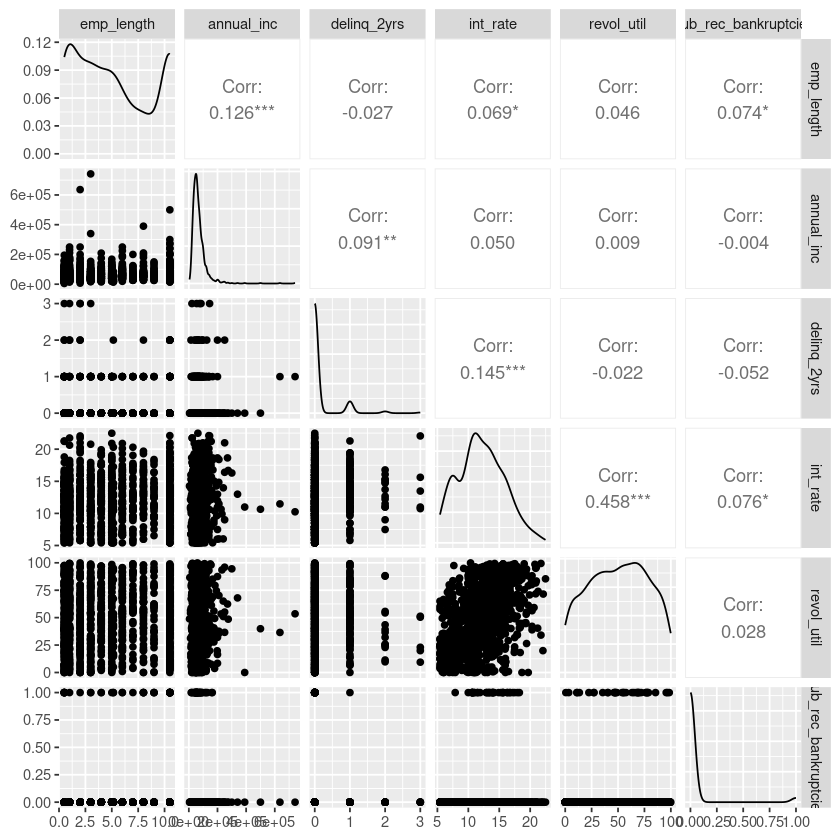

In [26]:
df.model %>%
    select_if(is.numeric) %>%
    sample_n(1000) %>% # for efficiency let's visualize 1000 random sample
    ggpairs()

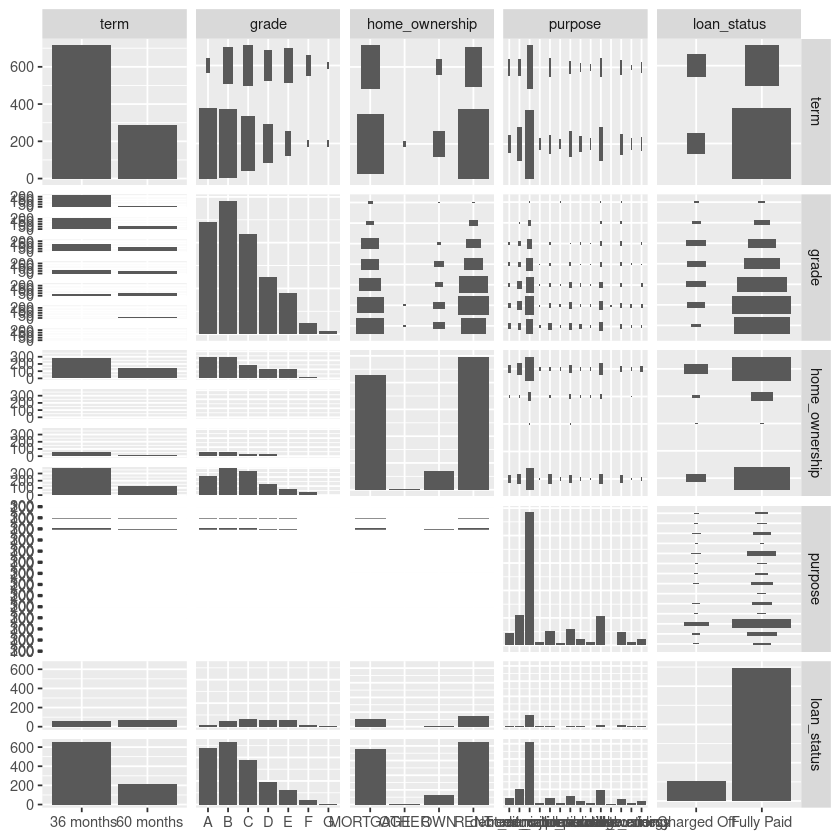

In [27]:
df.model %>%
    select_if(is.factor) %>%
    sample_n(1000) %>% # for efficiency let's visualize 1000 random sample
    ggpairs()

In practice, you will spend a lot of time to understand the visualizations. For instance:
* For numeric columns, if the distribution is skewed, please consider log transformation.
* For factor columns, if the distribution is not well balanced, please consider dropping rare factor levels.
* For column pairs, if the scatter plot is strongly correlated, please consider if we want to include both columns.

__Warning: we have some of these issues in the visualization__, but for the sake of time, I am going to assume everything is alright, and continue the modeling work. If you address some of these issues, you have a good chance to improve the modeling performances.

# Cross Validation

We prefer to use valid variable names for the class levels:

In [26]:
levels(df.model$loan_status) =  make.names(levels(df.model$loan_status))
table(df.model$loan_status)


Charged.Off  Fully.Paid 
       5670       34116 

We will split the data into two parts:
* `df.cv`: to be used for cross validation, e.g., to identify best algorithms and tune parameters.
* `df.holdout`: to be used only for evaluating the final models from cross validation. The holdout set should never be used during the cross validation process, e.g., selecting algorithms or tuning parameters.

Since our data is relative large, we will use 50% for cross validation and 50% for holdout. We will use the function `createDataPartition` which creates stratified partitions by class levels in its argument `y`.

In [27]:
ind = createDataPartition(y=df.model$loan_status, p=0.5, list=FALSE)
df.cv = df.model[ind, ]
df.holdout = df.model[-ind, ]

Let's check the balances of class levels:

In [28]:
table(df.cv$loan_status)
table(df.holdout$loan_status)


Charged.Off  Fully.Paid 
       2835       17058 


Charged.Off  Fully.Paid 
       2835       17058 

A helper function to check the model results and performances on holdoud data:

In [29]:
summary.holdout = function(fit, data=df.holdout){
    ret = list()
    fit.data = predict(fit, data, type='prob')
    fit.data = rename_with(fit.data, ~str_replace(., "^.pred_", ""))
    fit.pred = max.col(fit.data)
    fit.pred = colnames(fit.data)[fit.pred]
    fit.data$predicted = fit.pred
    fit.data$truth = data$loan_status
    fit.data$predicted = factor(fit.data$predicted, levels = levels(fit.data$truth))
    ret$cm = conf_mat(fit.data, truth, predicted)
    ret$cm.plot = autoplot(ret$cm)
    ret$cm.sum = summary(ret$cm)
    ret$roc = roc_auc(fit.data, truth, Charged.Off)
    ret$roc.plot = autoplot(roc_curve(fit.data, truth, Charged.Off))
    ret
}

Let's try decision tree model with cross validation.

Remember:
* Since the classes are not well balanced, we will use `ROC` instead of accuracy.
* For imbalanced classes, we may have addition evaluation requirements.

+ Fold1: cp=0.01 
- Fold1: cp=0.01 
+ Fold2: cp=0.01 
- Fold2: cp=0.01 
+ Fold3: cp=0.01 
- Fold3: cp=0.01 
+ Fold4: cp=0.01 
- Fold4: cp=0.01 
+ Fold5: cp=0.01 
- Fold5: cp=0.01 
Aggregating results
Selecting tuning parameters
Fitting cp = 1 on full training set


CART 

19893 samples
   10 predictor
    2 classes: 'Charged.Off', 'Fully.Paid' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 15914, 15914, 15914, 15915, 15915 
Resampling results across tuning parameters:

  cp          ROC  Sens  Spec
  0.01000000  0.5  0     1   
  0.03162278  0.5  0     1   
  0.10000000  0.5  0     1   
  0.31622777  0.5  0     1   
  1.00000000  0.5  0     1   

ROC was used to select the optimal model using the largest value.
The final value used for the model was cp = 1.

,cp,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.01000000,0.5,0,1,0,0,0
2,0.03162278,0.5,0,1,0,0,0
3,0.10000000,0.5,0,1,0,0,0
4,0.31622777,0.5,0,1,0,0,0
5,1.00000000,0.5,0,1,0,0,0


,cp
,<dbl>
5,1


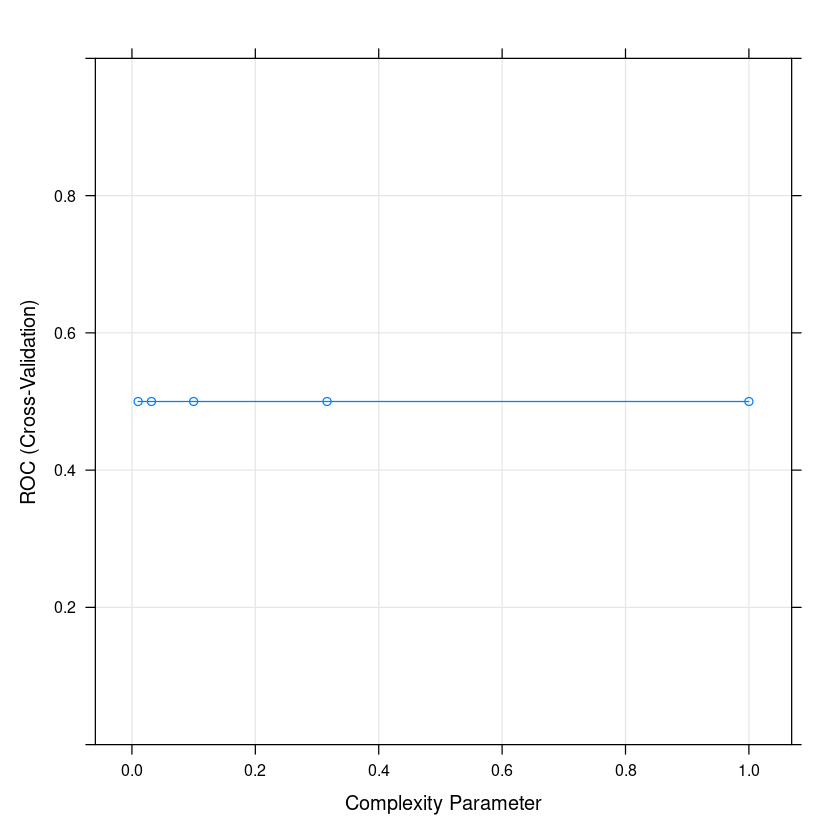

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”
Warning me

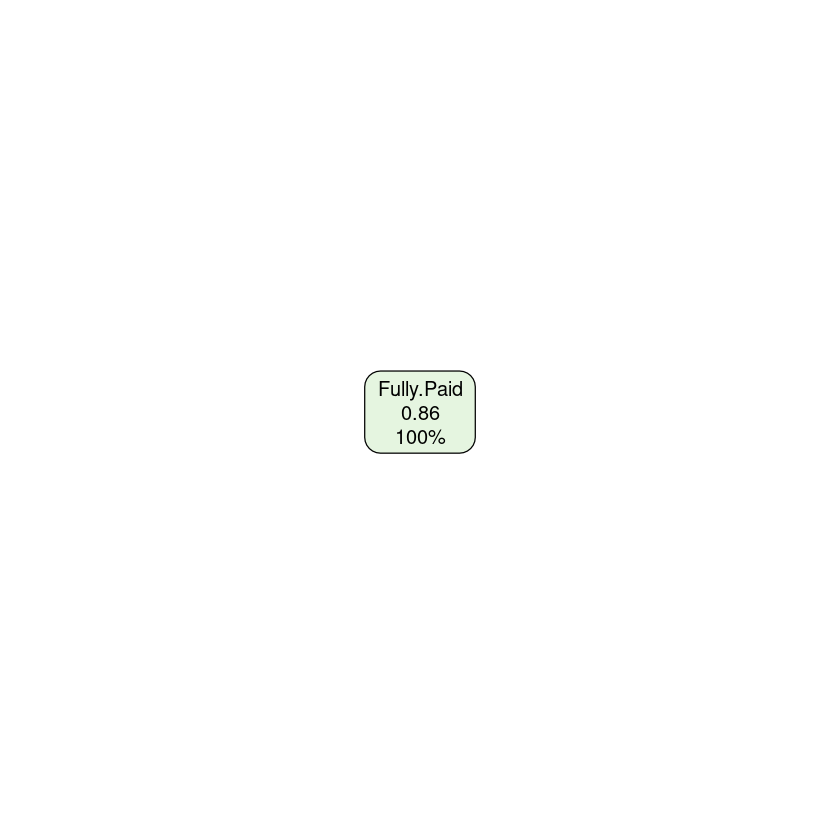

Warning message:
“While computing binary `precision()`, no predicted events were detected (i.e. `true_positive + false_positive = 0`). 
Precision is undefined in this case, and `NA` will be returned.
Note that 2835 true event(s) actually occured for the problematic event level, 'Charged.Off'.”
Warning message:
“While computing binary `precision()`, no predicted events were detected (i.e. `true_positive + false_positive = 0`). 
Precision is undefined in this case, and `NA` will be returned.
Note that 2835 true event(s) actually occured for the problematic event level, 'Charged.Off'.”


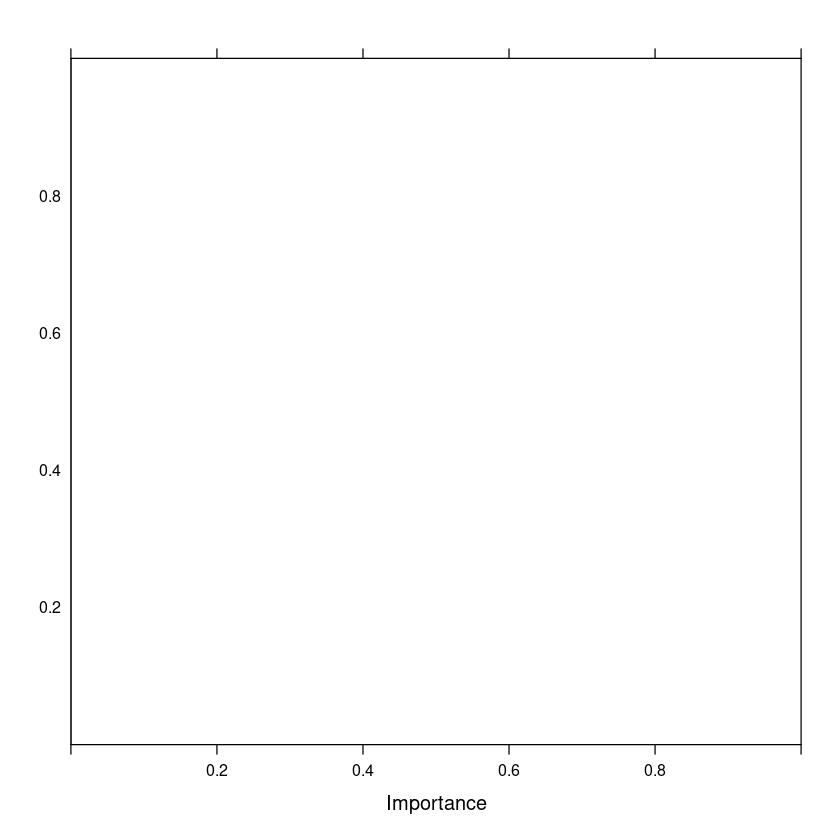

$cm
             Truth
Prediction    Charged.Off Fully.Paid
  Charged.Off           0          0
  Fully.Paid         2835      17058

$cm.plot

$cm.sum
# A tibble: 13 × 3
   .metric              .estimator .estimate
   <chr>                <chr>          <dbl>
 1 accuracy             binary         0.857
 2 kap                  binary         0    
 3 sens                 binary         0    
 4 spec                 binary         1    
 5 ppv                  binary       NaN    
 6 npv                  binary         0.857
 7 mcc                  binary        NA    
 8 j_index              binary         0    
 9 bal_accuracy         binary         0.5  
10 detection_prevalence binary         0    
11 precision            binary        NA    
12 recall               binary         0    
13 f_meas               binary        NA    

$roc
# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 roc_auc binary           0.5

$roc.plot


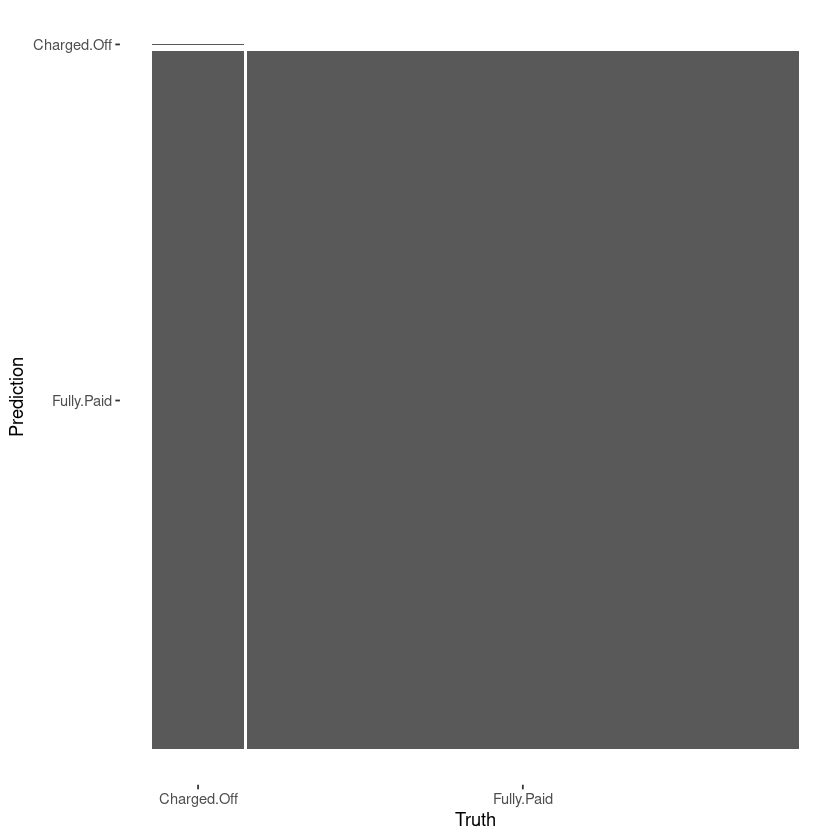

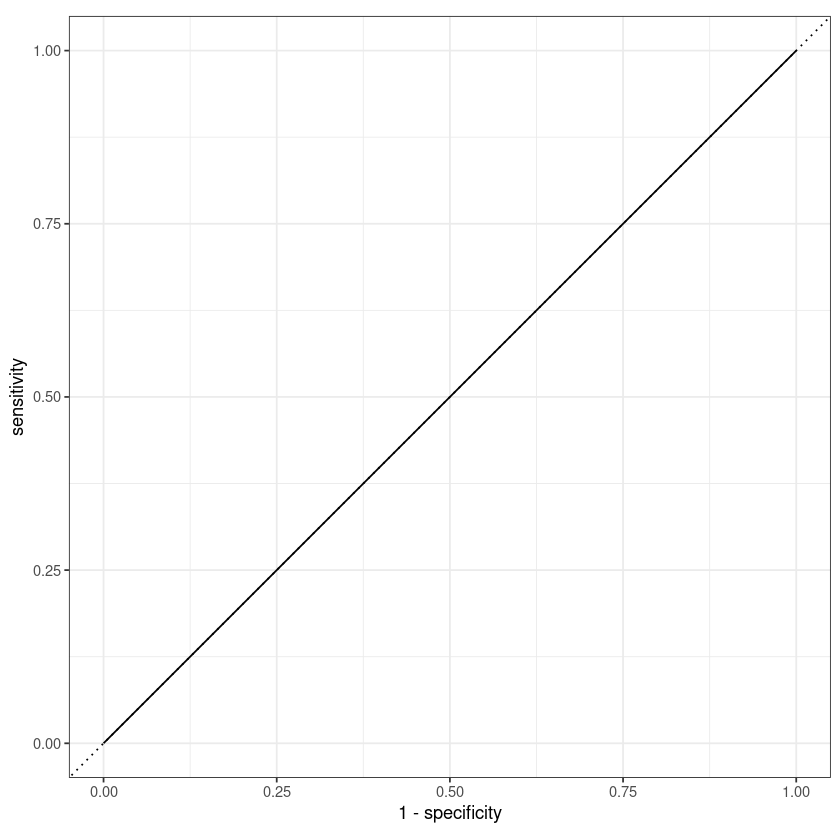

In [30]:
ctrl = trainControl(method = "cv", number = 5, classProbs = TRUE, summaryFunction = twoClassSummary, verboseIter = TRUE)

method = "rpart"
method.plot = rpart.plot
method.cp = 10^seq(from = -2, to = 0, by = 0.5)

fit.cv = train(loan_status ~ .,
        data = df.cv,
        method = method,
        tuneGrid = expand.grid(cp = method.cp),
        metric = "ROC",
        trControl = ctrl)

fit.cv

# results
fit.cv$results
fit.cv$bestTune
# plot
plot(fit.cv)
method.plot(fit.cv$finalModel)
plot(varImp(fit.cv))
# holdout
sum.cv=summary.holdout(fit.cv)
sum.cv

# How about downSample or upSample?

A disparity in the frequencies of the observed classes can have a significant negative impact on model fitting. One technique for resolving such a class imbalance is to subsample the training data in a manner that mitigates the issues.

[1] 5670   11


Charged.Off  Fully.Paid 
       2835        2835 

+ Fold1: cp=0.01 
- Fold1: cp=0.01 
+ Fold2: cp=0.01 
- Fold2: cp=0.01 
+ Fold3: cp=0.01 
- Fold3: cp=0.01 
+ Fold4: cp=0.01 
- Fold4: cp=0.01 
+ Fold5: cp=0.01 
- Fold5: cp=0.01 
Aggregating results
Selecting tuning parameters
Fitting cp = 0.01 on full training set


CART 

5670 samples
  10 predictor
   2 classes: 'Charged.Off', 'Fully.Paid' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 4536, 4536, 4536, 4536, 4536 
Resampling results across tuning parameters:

  cp          ROC        Sens       Spec     
  0.01000000  0.6286072  0.6567901  0.5964727
  0.03162278  0.6266314  0.6455026  0.6077601
  0.10000000  0.6266314  0.6455026  0.6077601
  0.31622777  0.5000000  1.0000000  0.0000000
  1.00000000  0.5000000  1.0000000  0.0000000

ROC was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.01.

,cp,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.01000000,0.6286072,0.6567901,0.5964727,0.009382915,0.01962354,0.03858768
2,0.03162278,0.6266314,0.6455026,0.6077601,0.012228596,0.00981969,0.01657285
3,0.10000000,0.6266314,0.6455026,0.6077601,0.012228596,0.00981969,0.01657285
4,0.31622777,0.5000000,1.0000000,0.0000000,0.000000000,0.00000000,0.00000000
5,1.00000000,0.5000000,1.0000000,0.0000000,0.000000000,0.00000000,0.00000000


,cp
,<dbl>
1,0.01


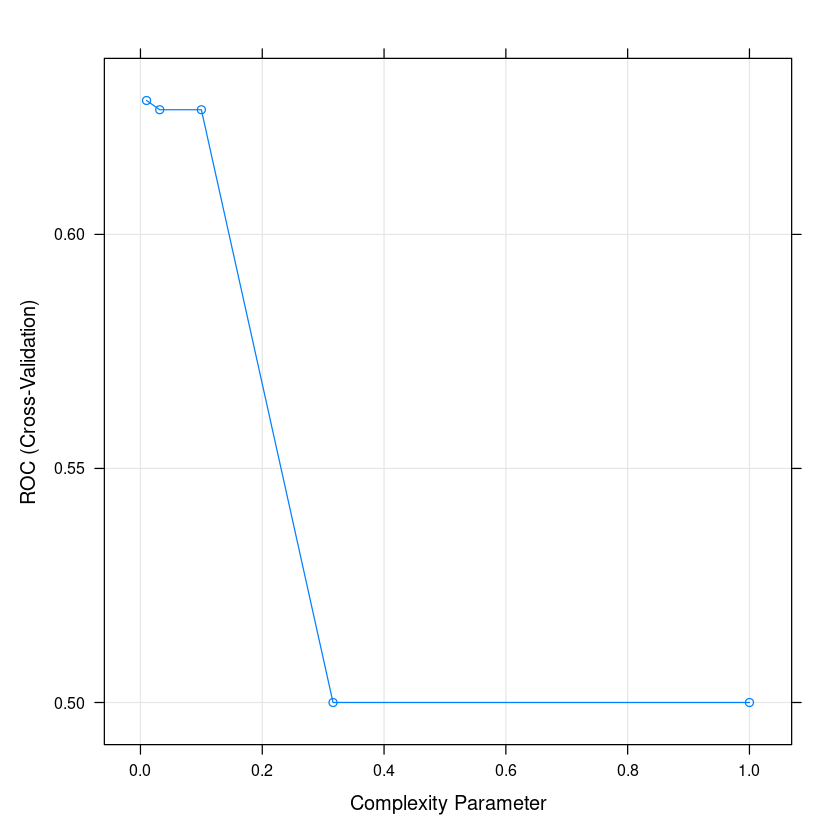

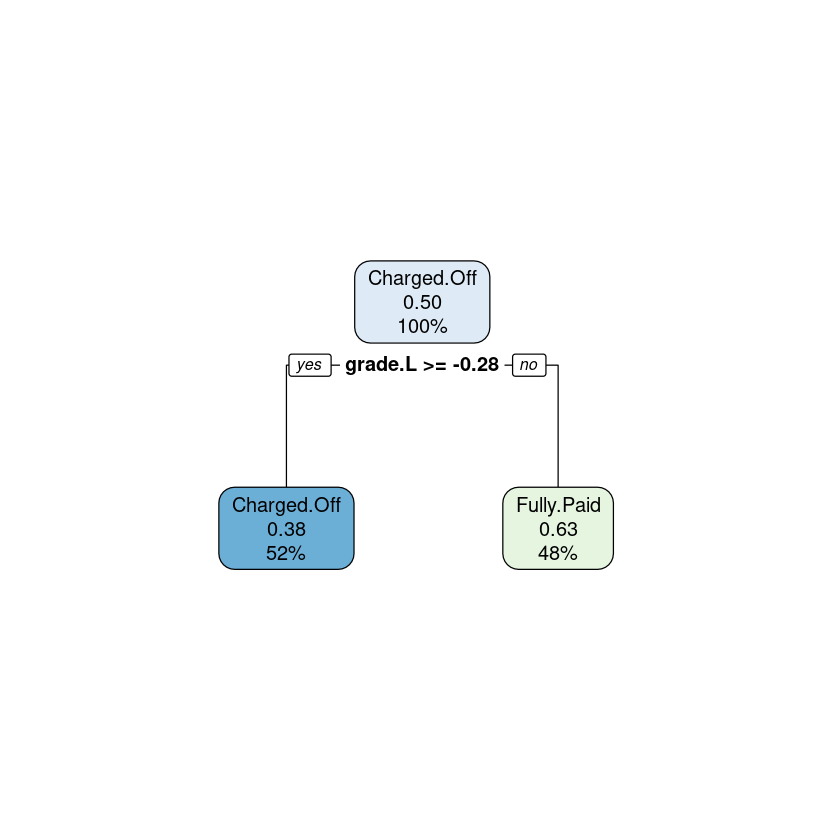

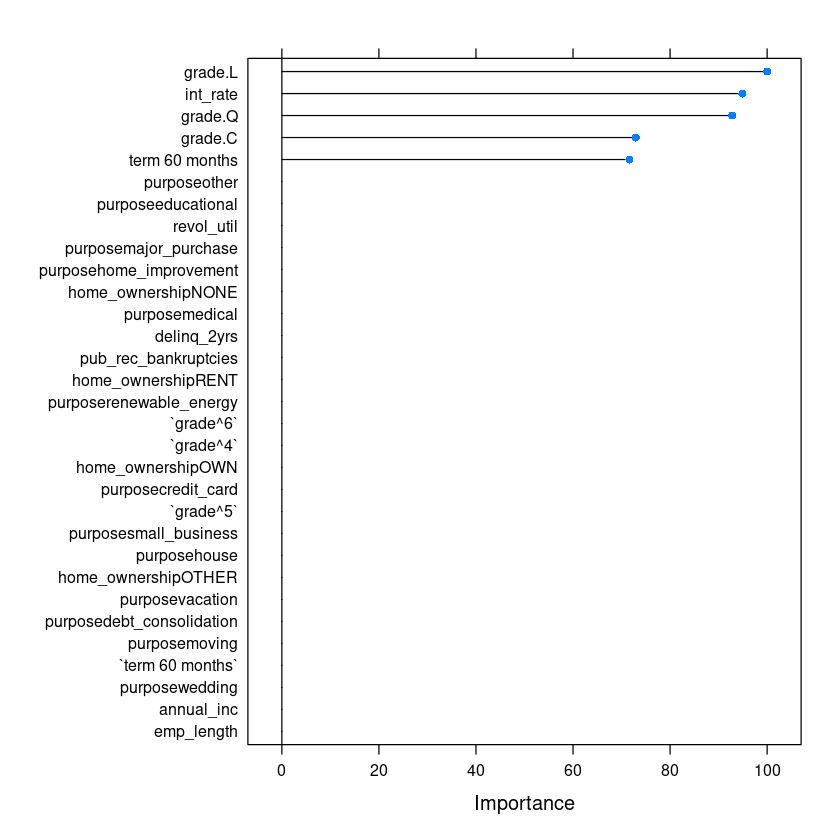

$cm
             Truth
Prediction    Charged.Off Fully.Paid
  Charged.Off        1805       7018
  Fully.Paid         1030      10040

$cm.plot

$cm.sum
# A tibble: 13 × 3
   .metric              .estimator .estimate
   <chr>                <chr>          <dbl>
 1 accuracy             binary         0.595
 2 kap                  binary         0.120
 3 sens                 binary         0.637
 4 spec                 binary         0.589
 5 ppv                  binary         0.205
 6 npv                  binary         0.907
 7 mcc                  binary         0.159
 8 j_index              binary         0.225
 9 bal_accuracy         binary         0.613
10 detection_prevalence binary         0.444
11 precision            binary         0.205
12 recall               binary         0.637
13 f_meas               binary         0.310

$roc
# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 roc_auc binary         0.613

$roc.plot


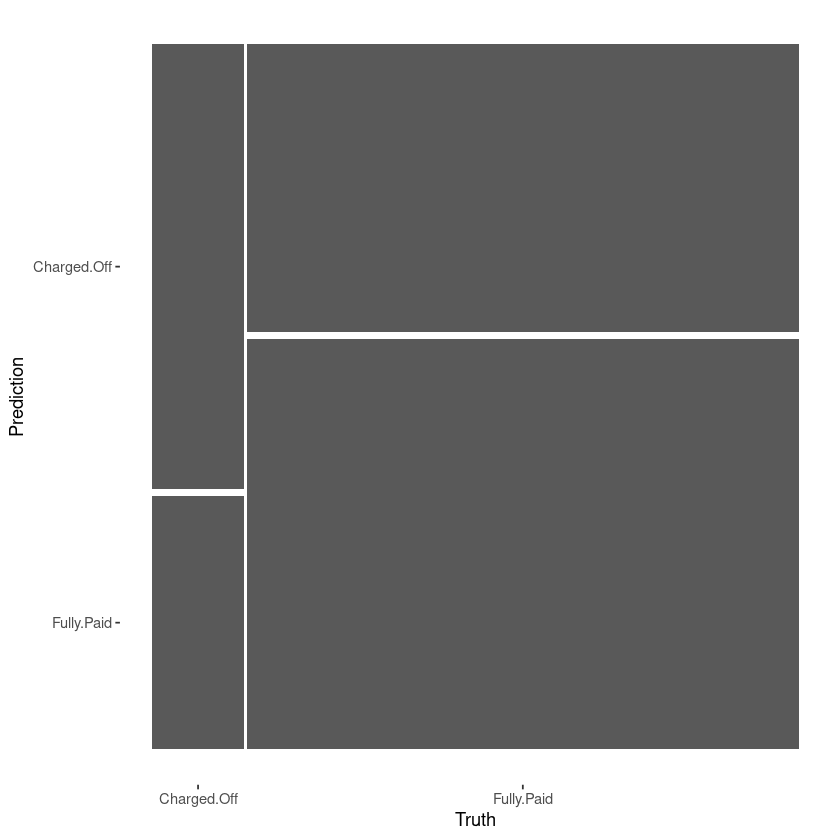

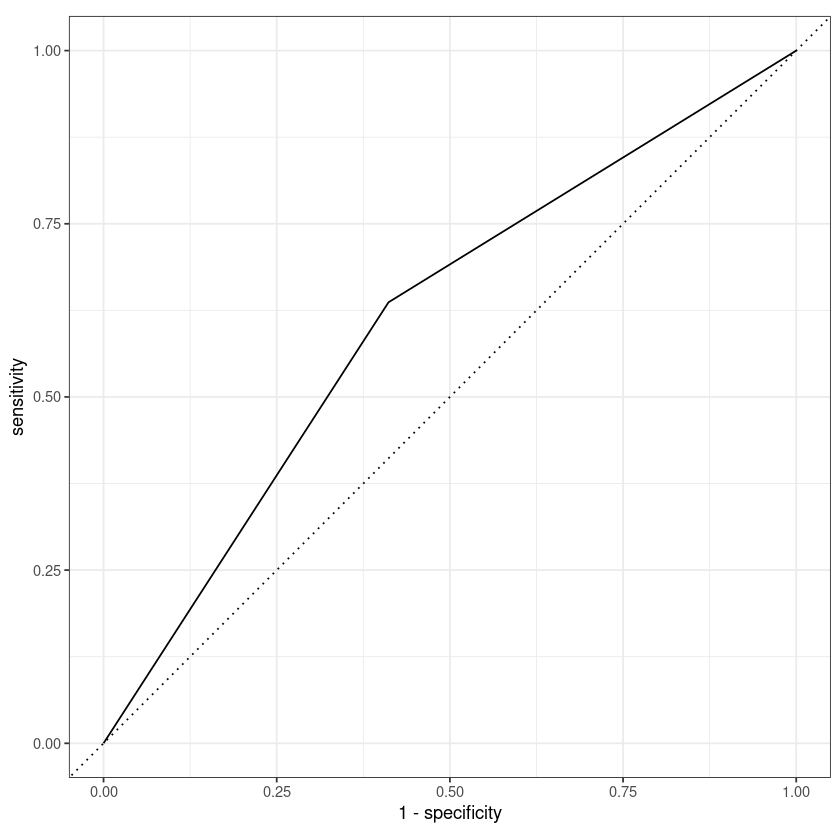

In [31]:
df.down = downSample(x=select(df.cv,-loan_status), y=df.cv$loan_status, yname = 'loan_status')
dim(df.down)
table(df.down$loan_status)

fit.down = train(loan_status ~ .,
        data = df.down,
        method = method,
        tuneGrid = expand.grid(cp = method.cp),
        metric = "ROC",
        trControl = ctrl)

fit.down

# results
fit.down$results
fit.down$bestTune
# plot
plot(fit.down)
method.plot(fit.down$finalModel)
plot(varImp(fit.down))
# holdout
sum.down=summary.holdout(fit.down)
sum.down

[1] 34116    11


Charged.Off  Fully.Paid 
      17058       17058 

+ Fold1: cp=0.01 
- Fold1: cp=0.01 
+ Fold2: cp=0.01 
- Fold2: cp=0.01 
+ Fold3: cp=0.01 
- Fold3: cp=0.01 
+ Fold4: cp=0.01 
- Fold4: cp=0.01 
+ Fold5: cp=0.01 
- Fold5: cp=0.01 
Aggregating results
Selecting tuning parameters
Fitting cp = 0.01 on full training set


CART 

34116 samples
   10 predictor
    2 classes: 'Charged.Off', 'Fully.Paid' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 27293, 27293, 27292, 27294, 27292 
Resampling results across tuning parameters:

  cp          ROC        Sens       Spec     
  0.01000000  0.6509728  0.6148997  0.6362433
  0.03162278  0.6133488  0.7446943  0.4820034
  0.10000000  0.6133488  0.7446943  0.4820034
  0.31622777  0.5000000  0.8000000  0.2000000
  1.00000000  0.5000000  0.8000000  0.2000000

ROC was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.01.

,cp,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.01000000,0.6509728,0.6148997,0.6362433,0.008469696,0.06001754,0.04620561
2,0.03162278,0.6133488,0.7446943,0.4820034,0.006386276,0.01135829,0.01199355
3,0.10000000,0.6133488,0.7446943,0.4820034,0.006386276,0.01135829,0.01199355
4,0.31622777,0.5000000,0.8000000,0.2000000,0.000000000,0.44721360,0.44721360
5,1.00000000,0.5000000,0.8000000,0.2000000,0.000000000,0.44721360,0.44721360


,cp
,<dbl>
1,0.01


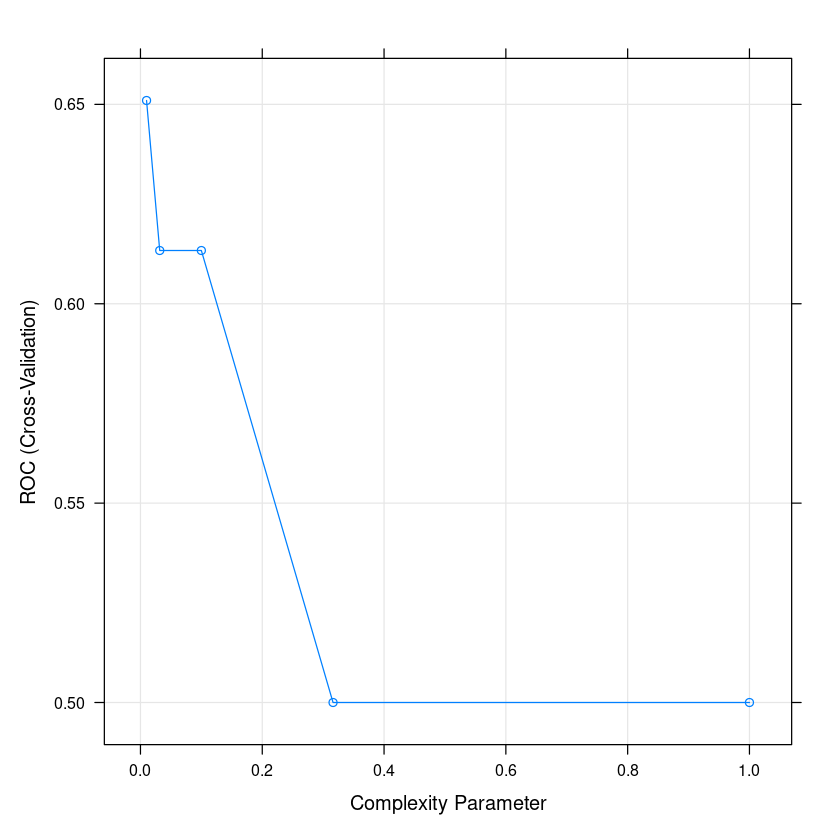

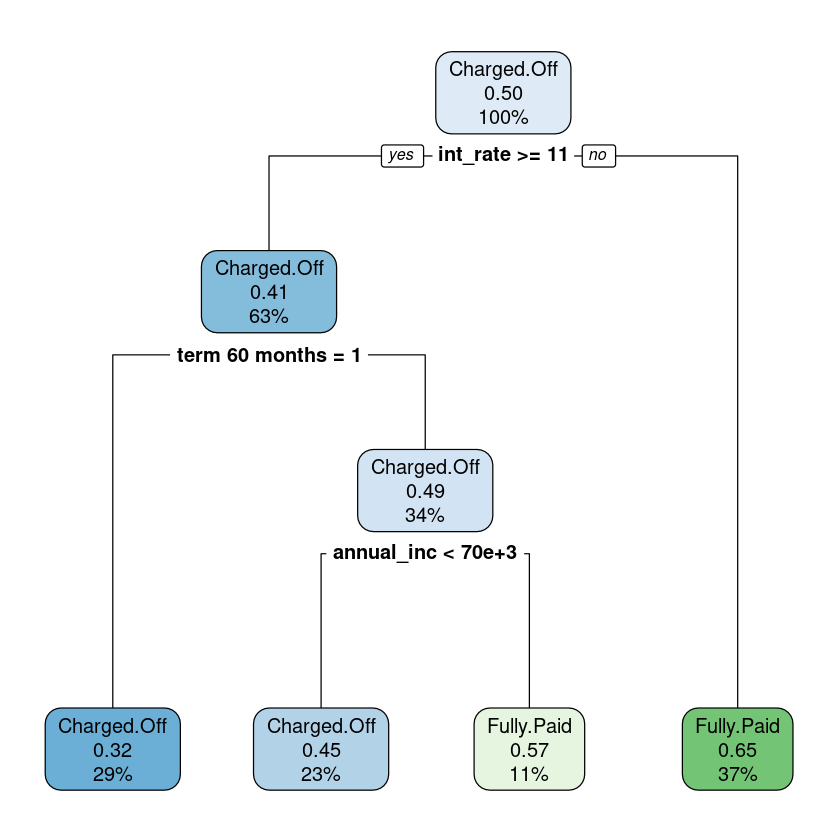

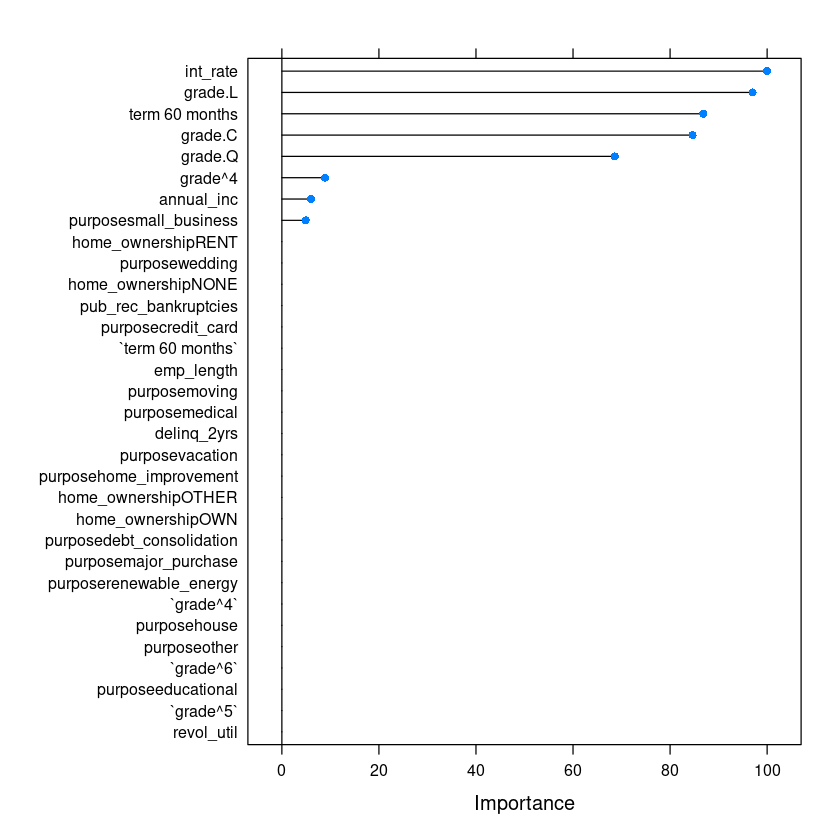

$cm
             Truth
Prediction    Charged.Off Fully.Paid
  Charged.Off        1809       6755
  Fully.Paid         1026      10303

$cm.plot

$cm.sum
# A tibble: 13 × 3
   .metric              .estimator .estimate
   <chr>                <chr>          <dbl>
 1 accuracy             binary         0.609
 2 kap                  binary         0.131
 3 sens                 binary         0.638
 4 spec                 binary         0.604
 5 ppv                  binary         0.211
 6 npv                  binary         0.909
 7 mcc                  binary         0.171
 8 j_index              binary         0.242
 9 bal_accuracy         binary         0.621
10 detection_prevalence binary         0.431
11 precision            binary         0.211
12 recall               binary         0.638
13 f_meas               binary         0.317

$roc
# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 roc_auc binary         0.641

$roc.plot


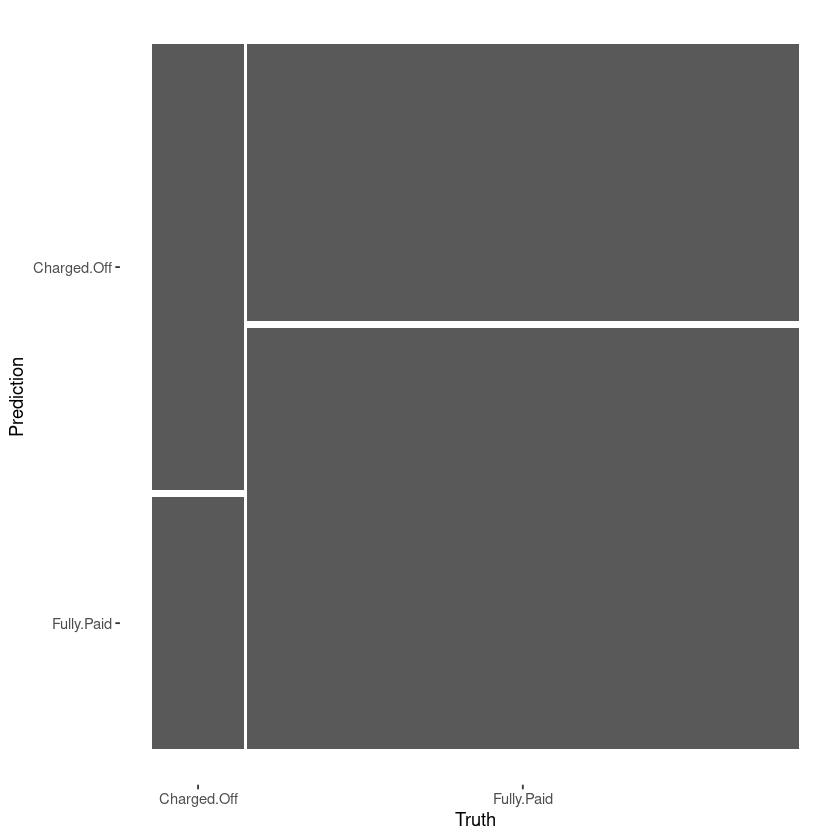

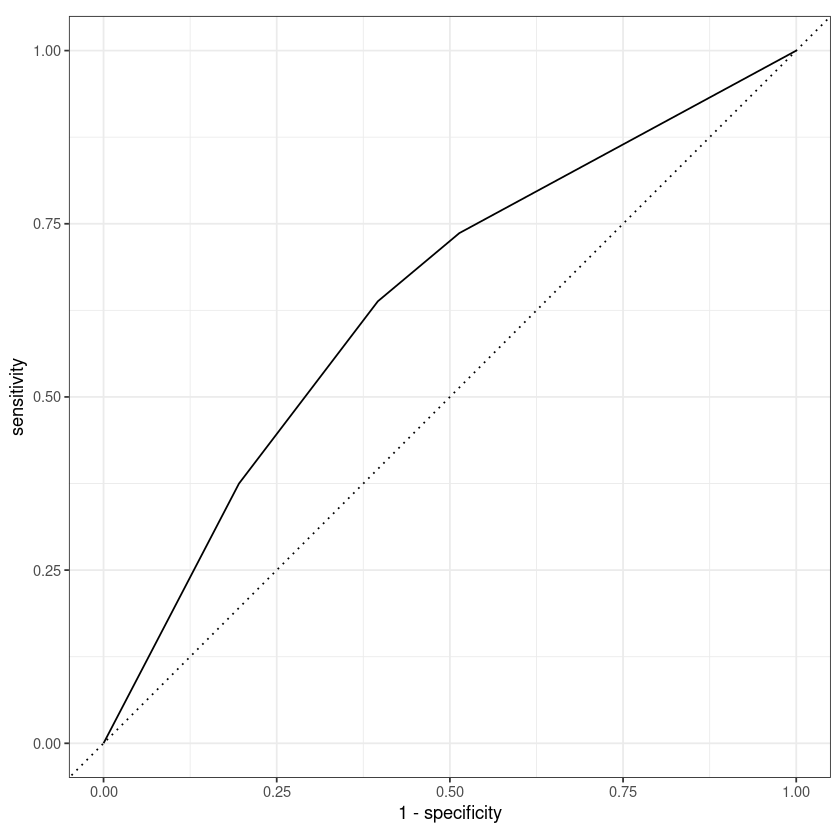

In [32]:
df.up = upSample(x=select(df.cv,-loan_status), y=df.cv$loan_status, yname = 'loan_status')
dim(df.up)
table(df.up$loan_status)

fit.up = train(loan_status ~ .,
        data = df.up,
        method = "rpart",
        tuneGrid = expand.grid(cp = method.cp),
        metric = "ROC",
        trControl = ctrl)

fit.up

# results
fit.up$results
fit.up$bestTune
# plot
plot(fit.up)
rpart.plot(fit.up$finalModel)
plot(varImp(fit.up))
# holdout
sum.up=summary.holdout(fit.up)
sum.up

# How about other models or additional data?

Please continue to try your own ideas ...

In [34]:
NNET <- train(loan_status~.,
              data=df.down,
              method="nnet",
              tuneGrid=expand.grid(size=3:7, decay=0.01),
              metric='ROC',
              trace=FALSE,
              #linout=TRUE,
              trControl=ctrl)

+ Fold1: size=3, decay=0.01 
- Fold1: size=3, decay=0.01 
+ Fold1: size=4, decay=0.01 
- Fold1: size=4, decay=0.01 
+ Fold1: size=5, decay=0.01 
- Fold1: size=5, decay=0.01 
+ Fold1: size=6, decay=0.01 
- Fold1: size=6, decay=0.01 
+ Fold1: size=7, decay=0.01 
- Fold1: size=7, decay=0.01 
+ Fold2: size=3, decay=0.01 
- Fold2: size=3, decay=0.01 
+ Fold2: size=4, decay=0.01 
- Fold2: size=4, decay=0.01 
+ Fold2: size=5, decay=0.01 
- Fold2: size=5, decay=0.01 
+ Fold2: size=6, decay=0.01 
- Fold2: size=6, decay=0.01 
+ Fold2: size=7, decay=0.01 
- Fold2: size=7, decay=0.01 
+ Fold3: size=3, decay=0.01 
- Fold3: size=3, decay=0.01 
+ Fold3: size=4, decay=0.01 
- Fold3: size=4, decay=0.01 
+ Fold3: size=5, decay=0.01 
- Fold3: size=5, decay=0.01 
+ Fold3: size=6, decay=0.01 
- Fold3: size=6, decay=0.01 
+ Fold3: size=7, decay=0.01 
- Fold3: size=7, decay=0.01 
+ Fold4: size=3, decay=0.01 
- Fold4: size=3, decay=0.01 
+ Fold4: size=4, decay=0.01 
- Fold4: size=4, decay=0.01 
+ Fold4: size=

,size,decay,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,0.01,0.5793103,0.4758377,0.6391534,0.10870306,0.45252859,0.40999051
2,4,0.01,0.6434534,0.5223986,0.6941799,0.08196052,0.29520090,0.17273870
3,5,0.01,0.6223709,0.4098765,0.7767196,0.10700660,0.37426897,0.20435583
4,6,0.01,0.6870487,0.6557319,0.6137566,0.02087326,0.04299157,0.02033962
5,7,0.01,0.6496882,0.5456790,0.6864198,0.09358723,0.30602976,0.17771705


,size,decay
,<int>,<dbl>
4,6,0.01


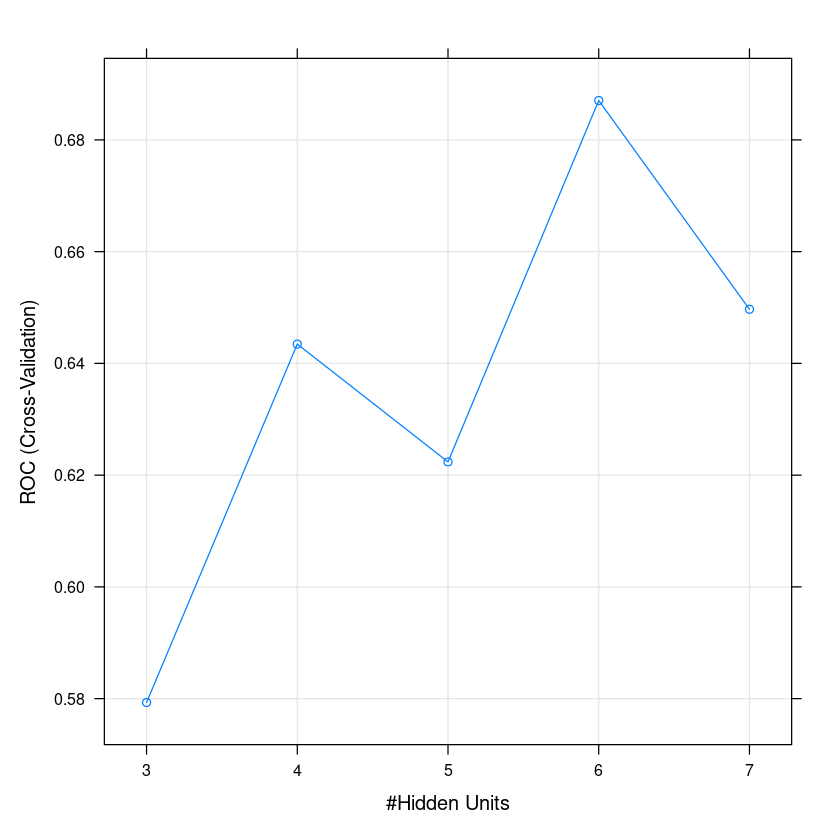

$cm
             Truth
Prediction    Charged.Off Fully.Paid
  Charged.Off        1919       6952
  Fully.Paid          916      10106

$cm.plot

$cm.sum
# A tibble: 13 × 3
   .metric              .estimator .estimate
   <chr>                <chr>          <dbl>
 1 accuracy             binary         0.604
 2 kap                  binary         0.143
 3 sens                 binary         0.677
 4 spec                 binary         0.592
 5 ppv                  binary         0.216
 6 npv                  binary         0.917
 7 mcc                  binary         0.189
 8 j_index              binary         0.269
 9 bal_accuracy         binary         0.635
10 detection_prevalence binary         0.446
11 precision            binary         0.216
12 recall               binary         0.677
13 f_meas               binary         0.328

$roc
# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 roc_auc binary         0.685

$roc.plot


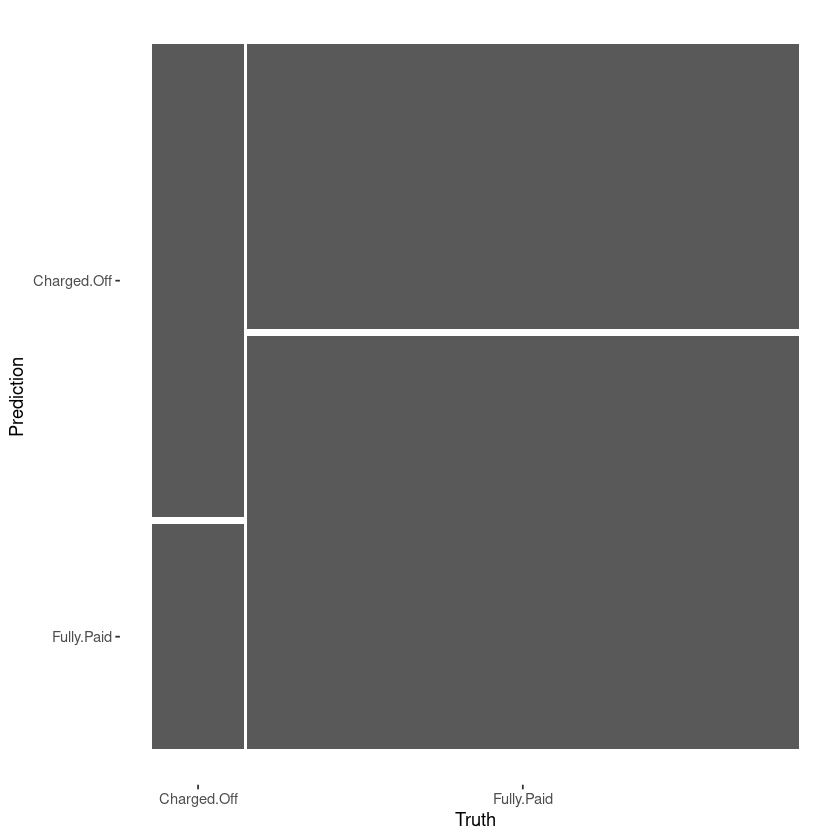

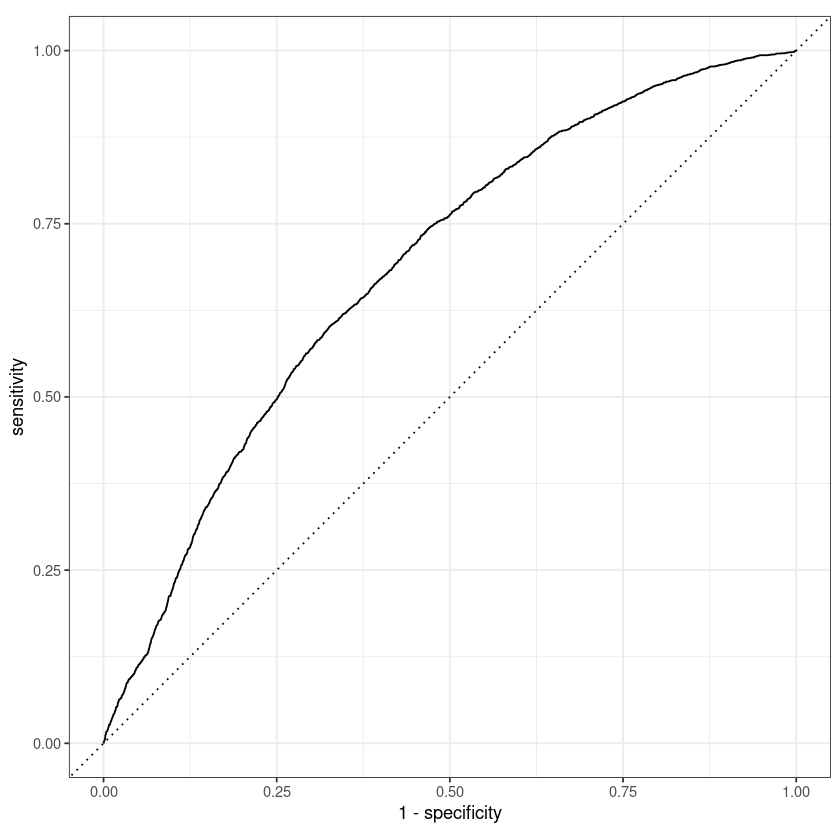

In [35]:
# results
NNET$results
NNET$bestTune
# plot
plot(NNET)
# holdout
sum.nn=summary.holdout(NNET)
sum.nn

# How about using tidymodels

In [36]:
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ recipes      1.0.8
✔ dials        1.2.0     ✔ rsample      1.2.0
✔ infer        1.0.5     ✔ tune         1.1.2
✔ modeldata    1.2.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard()    masks purrr::discard()
✖ dplyr::filter()      masks stats::filter()
✖ recipes::fixed()     masks stringr::fixed()
✖ dplyr::lag()         masks stats::lag()
✖ caret::lift()        masks purrr::lift()
✖ caret::precision()   masks yardstick::precision()
✖ dials::prune()       masks rpart::prune()
✖ caret::recall()      masks yardstick::recall()
✖ caret::sensitivity() masks yardstick::sensitivity()
✖ yardstick::spec()    masks readr::spec()
✖ caret::specificity() masks yardstick::specificity()
✖ recipes::step()      masks stats::step()
• Learn how to get started at https://www.tid

In [37]:
df.down.rec <- recipe(loan_status ~ ., df.down)

df.down.folds <- vfold_cv(df.down, 5)

decision_tree(mode='classification', cost_complexity=tune()) %>%
    tune_grid(df.down.rec, df.down.folds, grid = expand.grid(cost_complexity=method.cp), metrics = metric_set(roc_auc)) %>%
    collect_metrics()

cost_complexity,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
0.01000000,roc_auc,binary,0.6284762,5,0.008384895,Preprocessor1_Model1
0.03162278,roc_auc,binary,0.6192005,5,0.006155342,Preprocessor1_Model2
0.10000000,roc_auc,binary,0.6192005,5,0.006155342,Preprocessor1_Model3
0.31622777,roc_auc,binary,0.5000000,5,0.000000000,Preprocessor1_Model4
1.00000000,roc_auc,binary,0.5000000,5,0.000000000,Preprocessor1_Model5


In [38]:
mlp(mode = "classification", hidden_units = tune(), penalty = tune()) %>%
    tune_grid(df.down.rec, df.down.folds, grid = expand.grid(
        hidden_units = 3:7
        ,
        penalty = 0.01
    ), metrics = metric_set(roc_auc)) %>%
    collect_metrics()

hidden_units,penalty,.metric,.estimator,mean,n,std_err,.config
<int>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,0.01,roc_auc,binary,0.6886819,5,0.006799788,Preprocessor1_Model1
4,0.01,roc_auc,binary,0.6485862,5,0.035739081,Preprocessor1_Model2
5,0.01,roc_auc,binary,0.6844634,5,0.008484106,Preprocessor1_Model3
6,0.01,roc_auc,binary,0.6101168,5,0.045246431,Preprocessor1_Model4
7,0.01,roc_auc,binary,0.6123584,5,0.045938677,Preprocessor1_Model5
